In [1]:
# matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
import matplotlib

In [3]:
datadir = os.getcwd()
# datadir = '/run/user/1000/gvfs/sftp:host=amarillo.cs.ucdavis.edu/home/tamarnat/VRG-experiments/results/microbench/'

In [4]:
# SPEC2006 Benchmarks
all_spec_benchmarks = ['401.bzip2', '403.gcc', '410.bwaves', '416.gamess', '429.mcf', '433.milc', '434.zeusmp', 
                       '435.gromacs', '436.cactusADM', '437.leslie3d', '444.namd', '445.gobmk','453.povray', 
                       '454.calculix', '456.hmmer', '458.sjeng', '459.GemsFDTD','462.libquantum', '464.h264ref',
                       '465.tonto', '470.lbm', '471.omnetpp', '473.astar', '481.wrf', '482.sphinx3', '998.specrand',
                       '999.specrand']

spec_benchmarks = ['spec_benchmarks/'+ bm for bm in all_spec_benchmarks]
spec_benchmarks_names = ['445.gobmk','453.povray', '454.calculix', '456.hmmer', '458.sjeng', '459.GemsFDTD','462.libquantum']

In [5]:
# cpus
# cpus = ['atomic', 'timing', 'kvm', 'o3']
cpus= ['kvm', 'atomic']
print(cpus[0])

kvm


In [6]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    with open(filename) as f:
        r = f.read()
        if len(r) < 10: return 0.0
        start = r.find(stat) + len(stat) + 1
        end = r.find('#', start)
        return float(r[start:end])

In [7]:
# data frame for test data FS mode
#cdir1 = datadir + 'fs/test/'
rows = []
for cpu in cpus:
    cdir1 = datadir + '\\results\\' + cpu + '\\test\\'
    if cpu == 'kvm':
        kvm_benchmarks = os.listdir(cdir1)
    elif cpu == 'atomic':
        atomic_benchmarks = os.listdir(cdir1)
    for bm in os.listdir(cdir1):
        rows.append([cpu, bm,
                         gem5GetStat(cdir1 + bm, 'sim_ticks')/333, #1000
                         gem5GetStat(cdir1 + bm, 'sim_insts')/1000000000,
                         gem5GetStat(cdir1 + bm, 'sim_ops'),
                         gem5GetStat(cdir1 + bm, 'sim_ticks')/1e12,
                         gem5GetStat(cdir1 + bm, 'host_seconds')])

df1 = pd.DataFrame(rows, columns=['cpu', 'benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_time'])
df1['host_hours'] = df1['host_time']/3600
df1['ipc'] = df1['instructions']/df1['cycles']
df1['cpi'] = df1['cycles']/df1['instructions']
df1['opc'] = df1['ops']/df1['cycles']

In [8]:
# data frame for ref data FS mode
cpu = cpus[0]
rows = []
#for cpu in cpus1:
cdir2 = datadir + '\\results\\' + cpu + '\\ref\\'
if cpu == 'kvm':
    kvm_benchmarks = os.listdir(cdir2)
elif cpu == 'atomic':
    atomic_benchmarks = os.listdir(cdir2)
for bm in os.listdir(cdir1):
    rows.append([cpu, bm,
                     gem5GetStat(cdir2 + bm, 'sim_ticks')/333, #1000
                     gem5GetStat(cdir2 + bm, 'sim_insts')/1000000000,
                     gem5GetStat(cdir2 + bm, 'sim_ops'),
                     gem5GetStat(cdir2 + bm, 'sim_ticks')/1e12/60,
                     gem5GetStat(cdir2 + bm, 'host_seconds')/60])

df2 = pd.DataFrame(rows, columns=['cpu', 'benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_time'])
df2['host_hours'] = df2['host_time']/60
df2['ipc'] = df2['instructions']/df2['cycles']
df2['cpi'] = df2['cycles']/df2['instructions']
df2['opc'] = df2['ops']/df2['cycles']

In [9]:
# data frame for ref data FS mode atomic cpu
cpu = cpus[1]
rows = []
#for cpu in cpus1:
cdir2 = datadir + '\\results\\' + cpu + '\\test\\'
if cpu == 'kvm':
    kvm_benchmarks = os.listdir(cdir2)
elif cpu == 'atomic':
    atomic_benchmarks = os.listdir(cdir2)
for bm in os.listdir(cdir1):
    rows.append([cpu, bm,
                     gem5GetStat(cdir2 + bm, 'sim_ticks')/333, #1000
                     gem5GetStat(cdir2 + bm, 'sim_insts')/1000000000,
                     gem5GetStat(cdir2 + bm, 'sim_ops'),
                     gem5GetStat(cdir2 + bm, 'sim_ticks')/1e12/60,
                     gem5GetStat(cdir2 + bm, 'host_seconds')/60])

df3 = pd.DataFrame(rows, columns=['cpu', 'benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_time'])
df3['host_hours'] = df3['host_time']/60
df3['ipc'] = df3['instructions']/df3['cycles']
df3['cpi'] = df3['cycles']/df3['instructions']
df3['opc'] = df3['ops']/df3['cycles']

In [10]:
def plot_spec_benchmark(data_size, cpus, benchmarks, stat, norm=True):
    if data_size == 'test':
        data_frame = df1
    elif data_size == 'ref': 
        data_frame = df2
    plt.figure()
    i = 0
    for cpu in cpus:
        base = data_frame[(data_frame['cpu']==cpu)][stat].iloc[0] if norm else 1
        for j, bench in enumerate(benchmarks):
            a = data_frame[(data_frame['benchmark']==bench) & (data_frame['cpu']==cpu)]
            plt.bar(i, a[stat].iloc[0]/base, color='C'+str(j))
            i += 1

    for m,bm in enumerate(benchmarks):
        plt.bar(0,0,color='C'+str(m), label=bm)
    plt.xticks(np.arange(len(benchmarks)+1), benchmarks, rotation=40, ha='right')

In [11]:
def multi_plot(cpus, benchmarks, stat, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel):
    # Create Figure and Subplots
    figure, (ax1, ax2) = plt.subplots(1,2, sharey=False, dpi=120)

    # Plot
    i = 0
    for cpu in cpus:
        for j, bench in enumerate(kvm_benchmarks):
            a = df1[(df1['benchmark']==bench) & (df1['cpu']==cpu)]
            b = df2[(df2['benchmark']==bench) & (df2['cpu']==cpu)]
            ax1.bar(i, a[stat].iloc[0], color='C'+str(j))
            ax2.bar(i, b[stat].iloc[0], color='C'+str(j))
            i += 1
            
    # Title, X and Y labels  
    x = np.arange(len(kvm_benchmarks)+1)
    ax1.set_xticks(x);ax2.set_xticks(x)
    ax1.set_xticklabels(kvm_benchmarks, rotation=40, ha='right');ax2.set_xticklabels(kvm_benchmarks, rotation=40, ha='right')
    ax1.set_ylabel(ax1_ylabel);ax2.set_ylabel(ax2_ylabel)
    ax1.set_title(ax1_title);ax2.set_title(ax2_title);

## KVM CPU

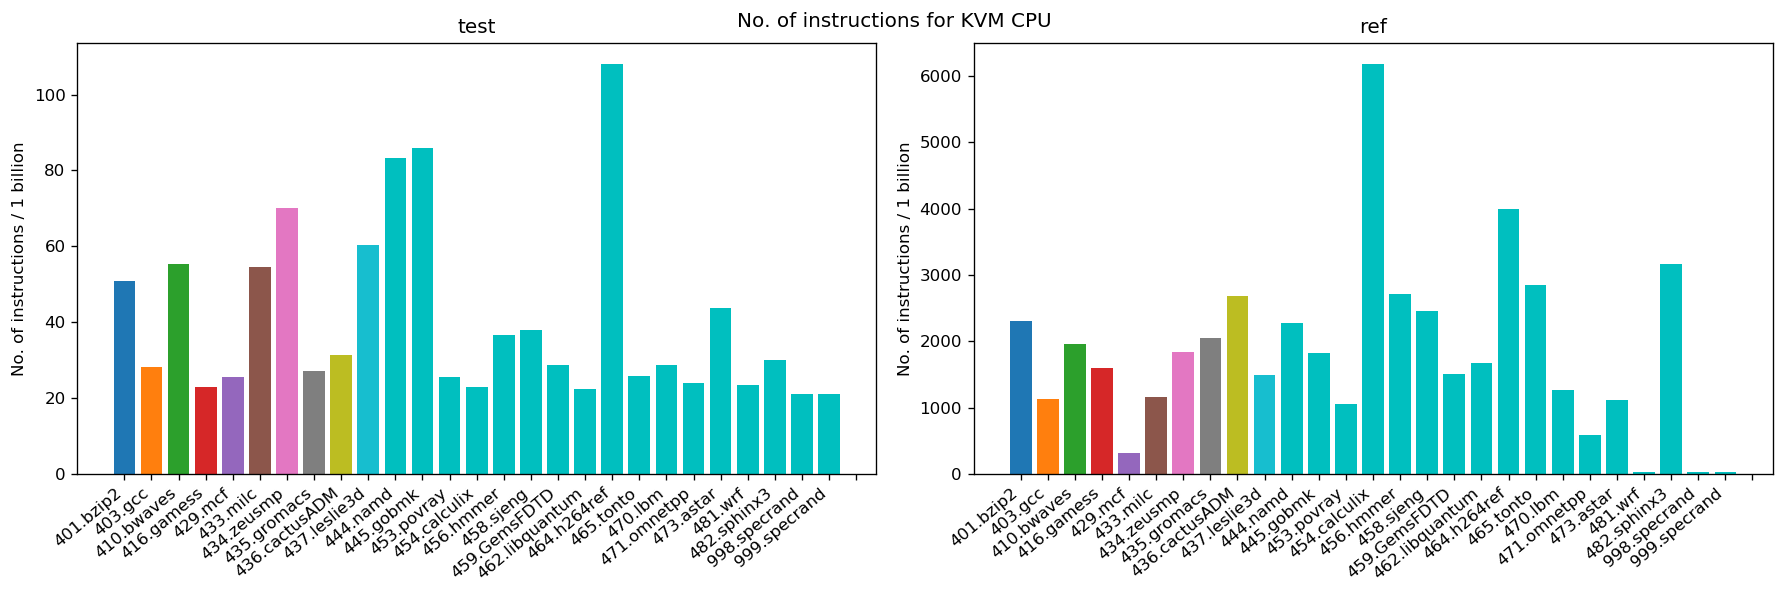

In [12]:
stat = 'instructions'
cpus = ['kvm']# This needs to be fixed
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
ax1_title = 'test'
ax2_title = 'ref'
ax1_ylabel = 'No. of ' + stat + ' / 1 billion'
ax2_ylabel = 'No. of ' + stat + ' / 1 billion'
multi_plot(cpus, kvm_benchmarks, stat, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' 
# plt.legend(loc=1, prop={'size': 8})
plt.suptitle('No. of instructions for KVM CPU')
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

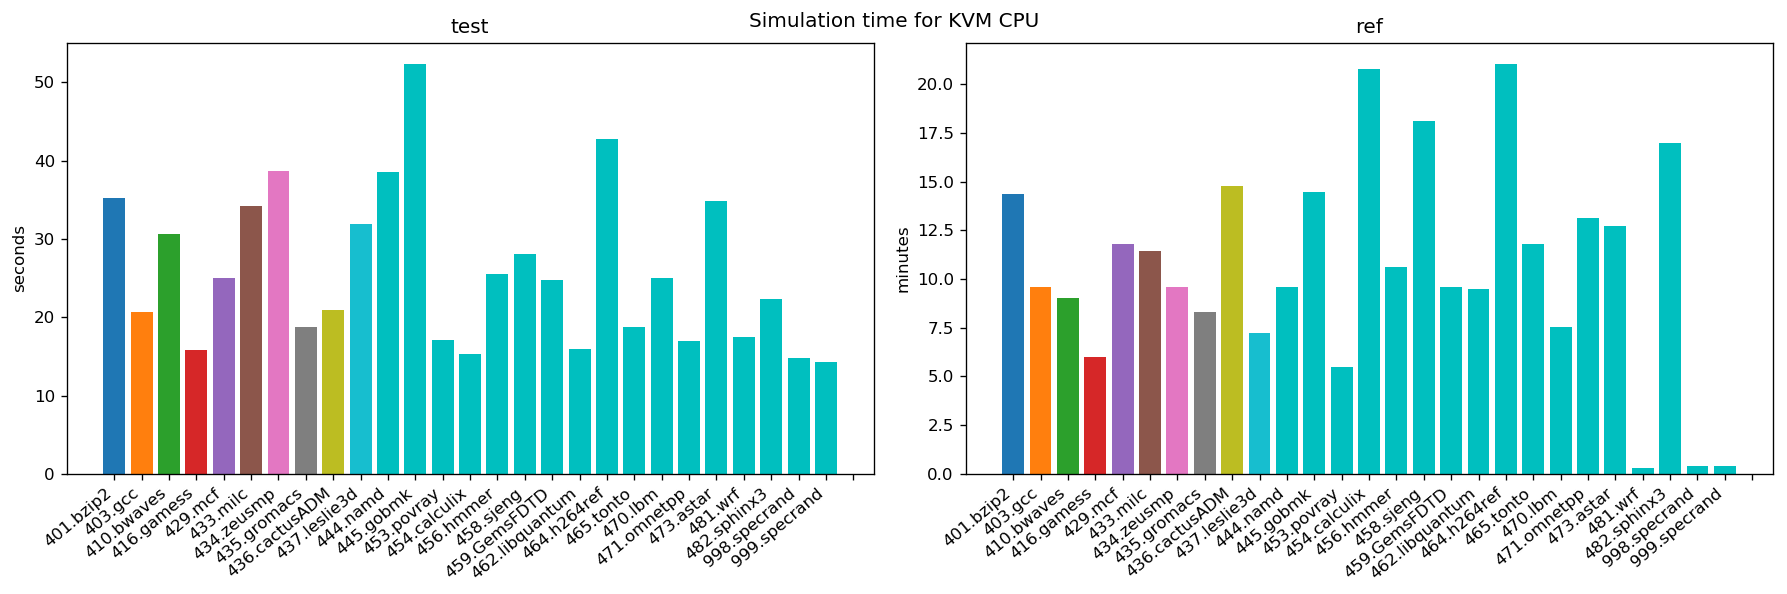

In [13]:
stat = 'sim_time'
cpus = ['kvm']# This needs to be fixed
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
ax1_title = 'test'
ax2_title = 'ref'
ax1_ylabel = 'seconds'
ax2_ylabel = 'minutes'
multi_plot(cpus, kvm_benchmarks, stat, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' 
# plt.legend(loc=1, prop={'size': 8})
plt.suptitle('Simulation time for KVM CPU')
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

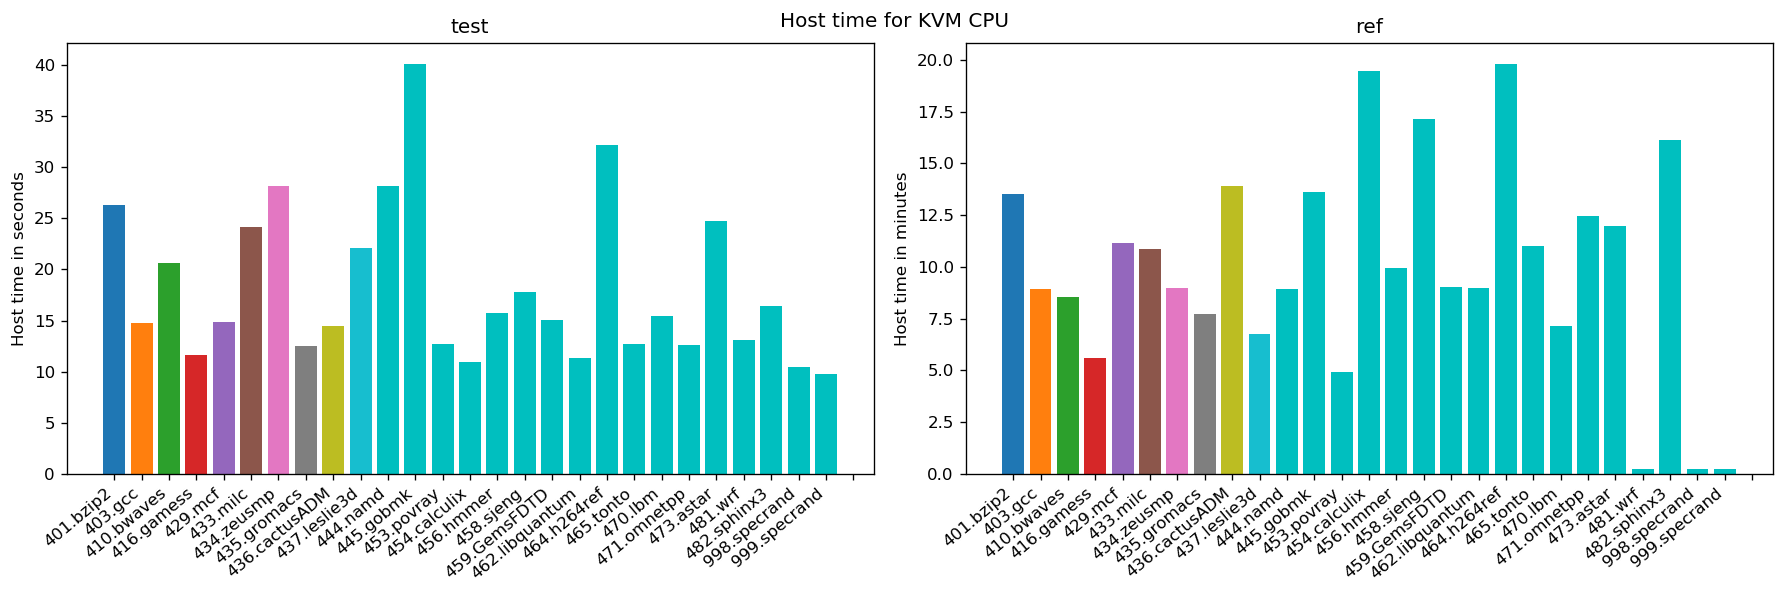

In [14]:
stat = 'host_time'
cpus = ['kvm']# This needs to be fixed
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
ax1_title = 'test'
ax2_title = 'ref'
ax1_ylabel = 'Host time in seconds'
ax2_ylabel = 'Host time in minutes'
multi_plot(cpus, kvm_benchmarks, stat, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' 
# plt.legend(loc=1, prop={'size': 8})
plt.suptitle('Host time for KVM CPU')
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

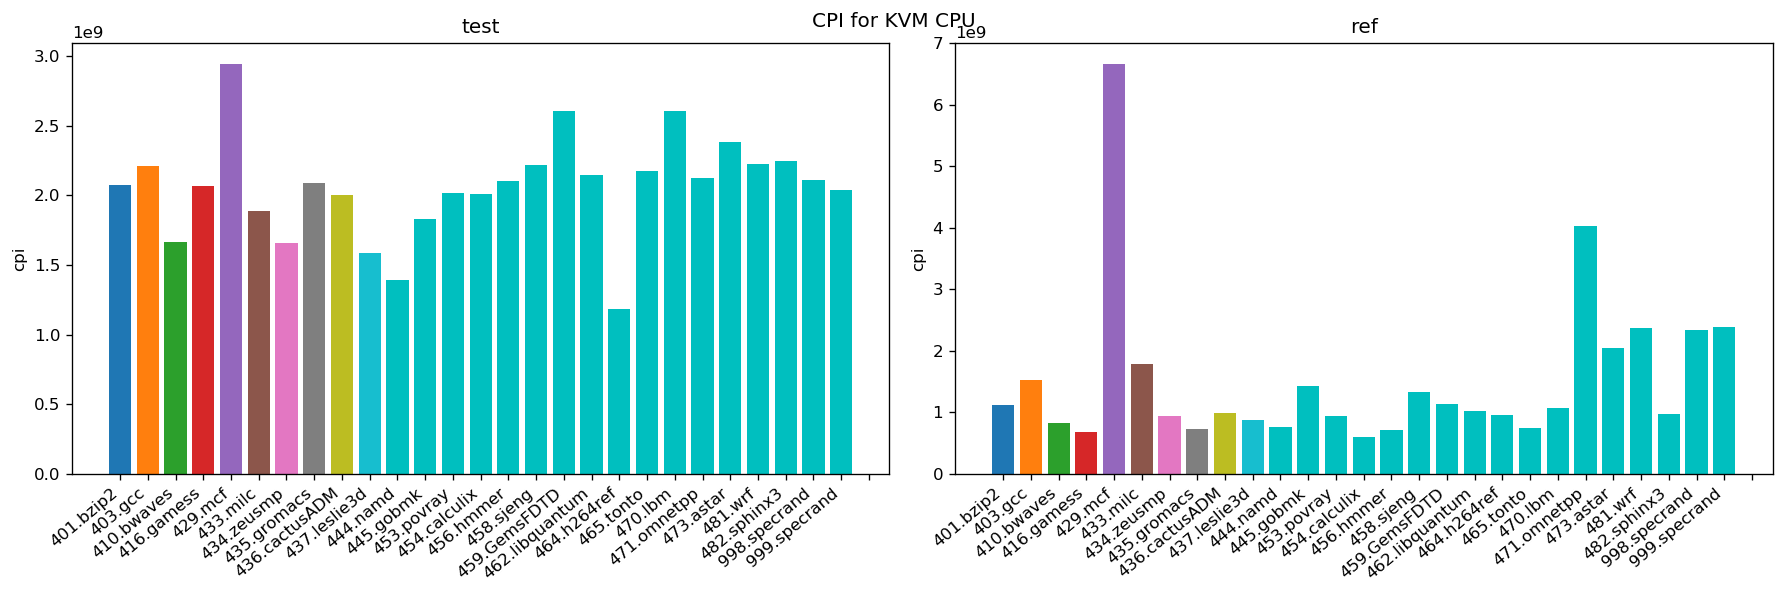

In [18]:
stat = 'cpi'
cpus = ['kvm']# This needs to be fixed
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
ax1_title = 'test'
ax2_title = 'ref'
ax1_ylabel = 'cpi'
ax2_ylabel = 'cpi'
multi_plot(cpus, kvm_benchmarks, stat, ax1_title, ax2_title, ax1_ylabel, ax2_ylabel)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' 
# plt.legend(loc=1, prop={'size': 8})
plt.suptitle('CPI for KVM CPU')
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

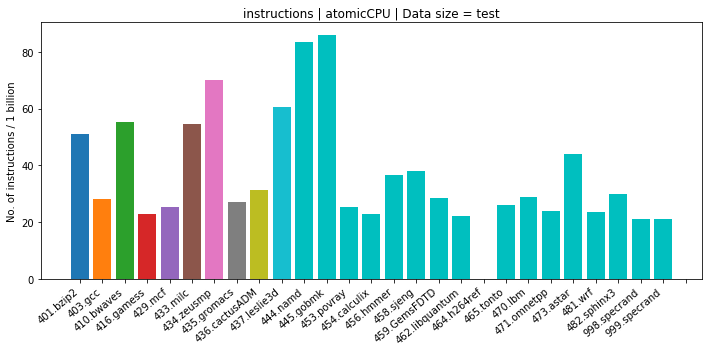

In [15]:
data_size = 'test'
stat = 'instructions'
cpus = ['atomic']# This needs to be fixed

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plot_spec_benchmark(data_size, cpus, atomic_benchmarks, stat, norm=False)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' + data_size + '\\' 
plt.ylabel('No. of ' + stat + ' / 1 billion')
# plt.legend(loc=1, prop={'size': 8})
plt.title(stat + ' | ' + cpus[0] + 'CPU' + ' | ' + 'Data size = ' + data_size)
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

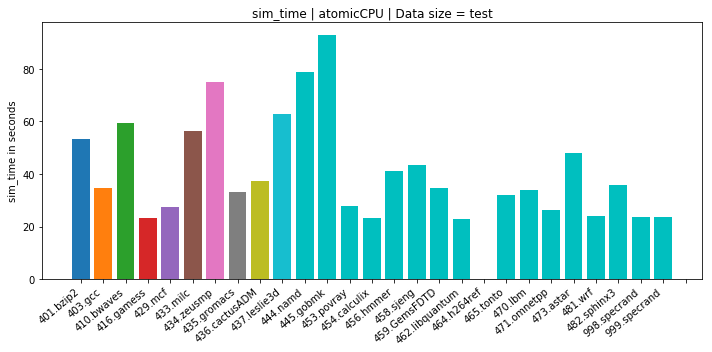

In [16]:
data_size = 'test'
stat = 'sim_time'
cpus = ['atomic']# This needs to be fixed

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plot_spec_benchmark(data_size, cpus, atomic_benchmarks, stat, norm=False)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' + data_size + '\\' 
plt.ylabel(stat + ' in seconds')
# plt.legend(loc=1, prop={'size': 8})
plt.title(stat + ' | ' + cpus[0] + 'CPU' + ' | ' + 'Data size = ' + data_size)
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)

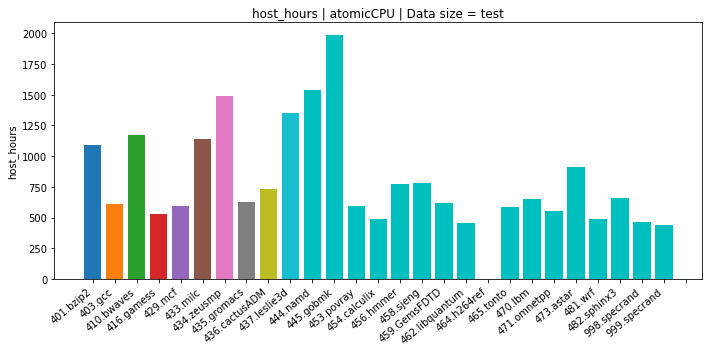

In [17]:
data_size = 'test'
stat = 'host_hours'
cpus = ['atomic']# This needs to be fixed

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plot_spec_benchmark(data_size, cpus, atomic_benchmarks, stat, norm=False)
# plot directory
plotdir = datadir + '\\plots\\' + cpus[0] + '\\' + data_size + '\\' 
plt.ylabel(stat)
# plt.legend(loc=1, prop={'size': 8})
plt.title(stat + ' | ' + cpus[0] + 'CPU' + ' | ' + 'Data size = ' + data_size)
plt.tight_layout()
plt.savefig(plotdir + stat + '.png', format='png', dpi=600)